In [2461]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [2462]:
def concat_df(df_train, df_test, time_col='time', time_split='2024-10-30'):
    df_train = df_train[df_train[time_col] < time_split]
    df_test = df_test[df_test[time_col] >= time_split]
    return pd.concat([df_train, df_test], axis=0, ignore_index=True)

In [2463]:
stock_relation1 = pd.read_csv("../dataset/news/relation_all.csv")
stock_relation2 = pd.read_csv("../dataset/news/relation_all_test.csv")
stock_relation = concat_df(stock_relation1, stock_relation2)
stock_relation['time'] = pd.to_datetime(stock_relation['time'])
stock_relation

,ticker,sentiment,sentiment_reasoning,news_id,source_ticker,time
0,NFLX,positive,The article indicates that significant investo...,d913f8609f0266a3934c767e3e08b5cb3a5b907373cf4c...,NFLX,2024-07-02 17:46:38
1,AMZN,positive,AWS is mentioned as one of the biggest names i...,8acd1c36c41725f571ef8611bcecdb9223800381a2543b...,MSFT,2024-07-02 17:46:57
2,MSFT,positive,Microsoft is mentioned as one of the prominent...,8acd1c36c41725f571ef8611bcecdb9223800381a2543b...,GOOGL,2024-07-02 17:46:57
3,GOOG,positive,Google is also mentioned as one of the promine...,8acd1c36c41725f571ef8611bcecdb9223800381a2543b...,GOOGL,2024-07-02 17:46:57
4,GOOGL,positive,Google is also mentioned as one of the promine...,8acd1c36c41725f571ef8611bcecdb9223800381a2543b...,GOOGL,2024-07-02 17:46:57
...,...,...,...,...,...,...
30144,PINS,negative,"Pinterest's revenue growth is decelerating, go...",784b3e4ed634caf42b5231185445266ad2ba5e496af7cb...,AMZN,2024-11-29 15:30:00
30145,AMZN,neutral,Amazon is facing slowing growth and increased ...,784b3e4ed634caf42b5231185445266ad2ba5e496af7cb...,AMZN,2024-11-29 15:30:00
30146,NVDA,neutral,The article provides an update on Nvidia but d...,35df0d912c3dfd75abf8102bd782257a02b725eab618c4...,NVDA,2024-11-29 15:41:31
30147,NVDA,positive,The Motley Fool has positions in and recommend...,f7662caac2faa279ca952fbb1b8f90fe30b6c575b50714...,NVDA,2024-11-29 15:42:45


<Axes: xlabel='time'>

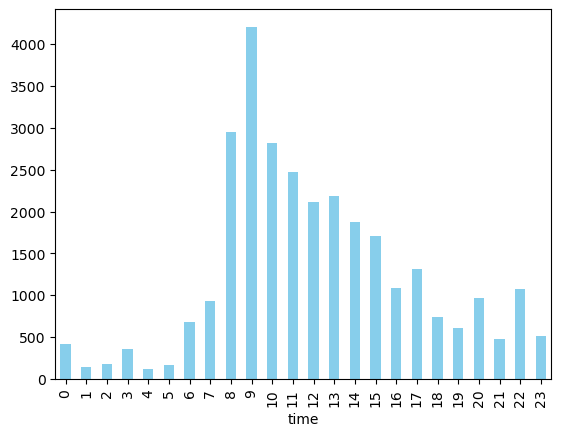

In [2464]:
stock_date = stock_relation['time'].dt.hour.value_counts().sort_index()
stock_date.plot(kind='bar', color='skyblue')

In [2465]:
def sentiment_transform(label):
    def func(series):
        return series.isin(label).sum() / series.count()
    return func

In [2466]:
def prepare_data(ticker, stock_relation):
    stock_price1 = pd.read_csv(f"../dataset/stocks/{ticker}.csv")
    stock_price2 = pd.read_csv(f"../dataset/stocks/{ticker}_test.csv")
    stock_price = concat_df(stock_price1, stock_price2)
    
    stock_price['time'] = pd.to_datetime(stock_price['time'])
    stock_price['trade_date'] = stock_price['time'].dt.date
    stock_price['delta'] = stock_price['close'].diff()
    stock_price['prv_close'] = stock_price['close'].shift(periods=1, fill_value=None)
    
    relation_t = stock_relation[stock_relation['ticker'] == ticker]
    relation_t['news_date'] = (relation_t['time'] + pd.to_timedelta(0, unit='h')).dt.date
    relation_t['same_source'] = (relation_t['source_ticker'] == relation_t['ticker']).astype(int)
    relation_t['direct_sentiment'] = relation_t['sentiment']
    relation_t.loc[relation_t['same_source'] == 0, 'direct_sentiment'] = 'None'

    news_comb = pd.merge(relation_t, stock_price, how='left', left_on='news_date', right_on='trade_date')
    # news_comb['trade_date'] = news_comb['trade_date'].fillna(method='bfill')
    news_comb = news_comb.dropna(subset=['trade_date'])
    news_comb['direct_sentiment'] = news_comb['sentiment']
    news_comb.loc[news_comb['source_ticker'] != news_comb['ticker'], 'direct_sentiment'] = 'None'

    relation_gp = news_comb.groupby('trade_date').agg({
        'prv_close': 'first', 'delta': 'first', 'close': 'first', 'open': 'first', 'high': 'first', 'low': 'first',
        'sentiment': [sentiment_transform(['positive', 'bullish']), sentiment_transform(['negative', 'bearish'])],
        'direct_sentiment': [sentiment_transform(['positive', 'bullish']), sentiment_transform(['negative', 'bearish'])],
    }).fillna(0.0).reset_index()
    relation_gp.columns = ['trade_date', 'prv_close', 'delta', 'close', 'open', 'high', 'low', 
                           'positive', 'negative', 'dir_positive', 'dir_negative']
    return relation_gp

In [2467]:
relation_gp = prepare_data(ticker='AAPL', stock_relation=stock_relation)
relation_gp_t = relation_gp[relation_gp['negative'] > 0]
len(relation_gp_t), len(relation_gp)

/var/folders/pj/znl5r0ln0hv_g1yjdthtr3f40000gn/T/ipykernel_6480/1638052838.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relation_t['news_date'] = (relation_t['time'] + pd.to_timedelta(0, unit='h')).dt.date
/var/folders/pj/znl5r0ln0hv_g1yjdthtr3f40000gn/T/ipykernel_6480/1638052838.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relation_t['same_source'] = (relation_t['source_ticker'] == relation_t['ticker']).astype(int)
/var/folders/pj/znl5r0ln0hv_g1yjdthtr3f40000gn/T/ipykernel_6480/1638052838.p

(59, 103)

In [2468]:
def test_relevance(cols):
    X, y = relation_gp_t[cols], relation_gp_t['delta']
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, r2, model.coef_

In [2469]:
test_relevance(['dir_negative', 'prv_close'])

(8.646529345492858, 0.26356620934724895, array([-13.06692784,  -0.19096334]))

In [2470]:
test_relevance(['negative', 'prv_close'])

(9.236442002349742, 0.2133227420918461, array([-9.13538785, -0.17902409]))

In [2471]:
test_relevance(['dir_negative', 'negative', 'prv_close'])

(8.637421594961276,
 0.2643419258203318,
 array([-11.89691661,  -1.22323174,  -0.19026006]))

In [2472]:
test_relevance(['dir_positive', 'prv_close'])

(10.37467928532561, 0.11637790290025174, array([ 4.67726086, -0.17405259]))

In [2473]:
test_relevance(['dir_negative', 'dir_positive', 'prv_close'])

(8.564210587220412,
 0.27057738259076614,
 array([-12.63766915,   2.67724765,  -0.192174  ]))

In [2474]:
test_relevance(['dir_negative', 'negative', 'dir_positive', 'prv_close'])

(8.539731980430153,
 0.2726622506884896,
 array([-10.63121816,  -2.04737379,   2.9775835 ,  -0.19113268]))

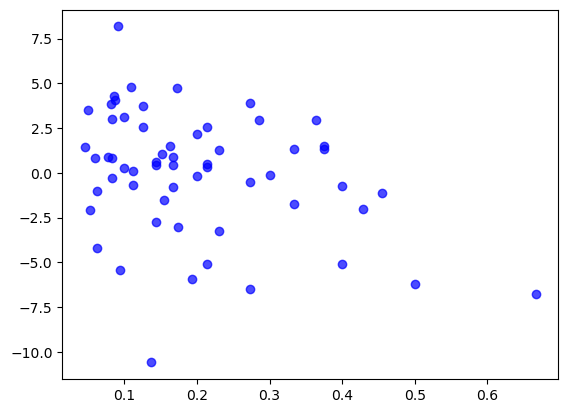

In [2475]:
import matplotlib.pyplot as plt

plt.scatter(relation_gp_t['negative'], relation_gp_t['delta'], color='blue', alpha=0.7)

In [2476]:
def preprocess(relation_gp):
    seq_length = 10
    std_scaler, max_scaler = StandardScaler(), MinMaxScaler()
    score_cols = ['dir_negative', 'negative', 'dir_positive', 'positive', 'close']
    price_cols = ['close']

    df = pd.DataFrame()
    df[score_cols] = std_scaler.fit_transform(relation_gp[score_cols])
    # df[price_cols] = max_scaler.fit_transform(relation_gp[price_cols])

    X = []
    y = []
    for i in range(seq_length, len(df)):
        X.append(df.iloc[i-seq_length:i])
        y.append(df.iloc[i, -1])
    X = np.array(X)
    y = np.array(y)

    split_index = int(len(X) * 0.8)
    X_train, X_val, X_test = X[:split_index], X[split_index::2], X[split_index+1::2]
    y_train, y_val, y_test = y[:split_index], y[split_index::2], y[split_index+1::2]

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) 
    y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1) 
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1) 

    return X_train, X_val, X_test, y_train, y_val, y_test

In [2477]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, layers, dropout):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

In [2478]:
model = SimpleLSTM(input_size=5, hidden_size=64, output_size=1, layers=2, dropout=0.2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_train, X_val, X_test, y_train, y_val, y_test = preprocess(relation_gp)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

(torch.Size([74, 10, 5]),
 torch.Size([10, 10, 5]),
 torch.Size([9, 10, 5]),
 torch.Size([74, 1]),
 torch.Size([10, 1]),
 torch.Size([9, 1]))

In [2479]:
class EarlyStopper:
    def __init__(self, min_steps=0, mem_ratio=1, threshold=0):
        self.min_steps = min_steps
        self.mem_ratio = mem_ratio
        self.threshold = threshold
        self.aveg_loss = 0
        self.steps = 0
        self.min_loss = float('inf')

    def early_stop(self, loss):
        self.steps += 1;
        self.aveg_loss = self.aveg_loss * self.mem_ratio + loss * (1-self.mem_ratio)
        if self.steps >= self.min_steps:
            self.min_loss = min(self.min_loss, self.aveg_loss)
            if self.aveg_loss >= self.min_loss * (1+self.threshold):
                return True
        return False

In [2480]:
num_epochs = 1000
early_stopping = EarlyStopper(min_steps=200, mem_ratio=0.95, threshold=0.05)
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val).item()
    
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")
    
    # Early stopping check
    if early_stopping.early_stop(val_loss):
        break

Epoch 1, Train Loss: 1.1538, Val Loss: 0.5066
Epoch 2, Train Loss: 1.1348, Val Loss: 0.5146
Epoch 3, Train Loss: 1.1220, Val Loss: 0.5231
Epoch 4, Train Loss: 1.1046, Val Loss: 0.5325
Epoch 5, Train Loss: 1.0879, Val Loss: 0.5428
Epoch 6, Train Loss: 1.0731, Val Loss: 0.5542
Epoch 7, Train Loss: 1.0587, Val Loss: 0.5668
Epoch 8, Train Loss: 1.0420, Val Loss: 0.5806
Epoch 9, Train Loss: 1.0247, Val Loss: 0.5957
Epoch 10, Train Loss: 1.0055, Val Loss: 0.6125
Epoch 11, Train Loss: 0.9857, Val Loss: 0.6308
Epoch 12, Train Loss: 0.9652, Val Loss: 0.6502
Epoch 13, Train Loss: 0.9398, Val Loss: 0.6703
Epoch 14, Train Loss: 0.9158, Val Loss: 0.6907
Epoch 15, Train Loss: 0.8920, Val Loss: 0.7099
Epoch 16, Train Loss: 0.8688, Val Loss: 0.7269
Epoch 17, Train Loss: 0.8311, Val Loss: 0.7403
Epoch 18, Train Loss: 0.7990, Val Loss: 0.7477
Epoch 19, Train Loss: 0.7585, Val Loss: 0.7479
Epoch 20, Train Loss: 0.7303, Val Loss: 0.7387
Epoch 21, Train Loss: 0.7029, Val Loss: 0.7187
Epoch 22, Train Loss: 

In [2481]:
model.eval()

with torch.no_grad():
    outputs = model(X_test)
    loss = criterion(outputs, y_test)
    std = y_test.std()
    print(f'Test Loss: {loss.item():.4f}')
    print(f'Std: {std:.4f}')
    print(f'Error Range: {loss.sqrt() / std:.4f}')

Test Loss: 0.2986
Std: 0.7024
Error Range: 0.7779
